In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [80]:
train_file = pd.read_csv('https://drive.google.com/uc?id=16dGSp_T6FhylyckqWJEXQzUi5sZH0heW') ## train.csv
target_file = pd.read_csv('https://drive.google.com/uc?id=1QCZa0_m1WzW2OsJYzJXOWY4QFnvFFfmK') ## target.csv
test_file = pd.read_csv('https://drive.google.com/uc?id=18wzEa16ntCFSup1VSF028pGqoGayejuH') ## test.csv


# train_file = pd.read_csv('train.csv') ## train.csv
# target_file = pd.read_csv('target.csv') ## target.csv
# test_file = pd.read_csv('test.csv') ## test.csv

train_copy = train_file.copy() ## untuk perbandingan nanti
target_copy = target_file.copy() ## untuk perbandingan nanti
test_copy = test_file.copy() ## untuk perbandingan nanti


In [81]:
train = pd.concat([train_file,target_file["coppaRisk"]], axis =1)
train['coppaRisk'] = train['coppaRisk'].astype(int)
test = test_file.copy()

## Exploratory Data Analysis

In [82]:
# Basic information
print("Dataset shape:", train.shape)
print("\nData types:")
print(train.dtypes)

# Missing values
missing = train.isnull().sum()
missing_percent = 100 * missing / len(train)
missing_data = pd.DataFrame({'Missing Count': missing,
                             'Missing Percent': missing_percent})
print("\nMissing values:")
print(missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Percent', ascending=False))

# Target variable
print("\nTarget variable distribution:")
print(train['coppaRisk'].value_counts())
print(100 * train['coppaRisk'].value_counts() / len(train))

# Add numeric version of target for analysis
train['coppaRisk_numeric'] = (train['coppaRisk'] == True).astype(int)

# Numeric features basic stats
numeric_cols = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']
print("\nNumeric columns statistics:")
print(train[numeric_cols].describe())

# Skewness
print("\nSkewness of numeric features:")
print(train[numeric_cols].skew())

# Enhanced categorical analysis
categorical_cols = [
    'developerCountry', 'countryCode', 'primaryGenreName', 'deviceType',
    'hasPrivacyLink', 'hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating',
    'appContentBrandSafetyRating', 'appDescriptionBrandSafetyRating', 'mfaRating'
]

print("\n" + "="*50)
print("CATEGORICAL COLUMNS ANALYSIS")
print("="*50)

for col in categorical_cols:
    unique_values = train[col].nunique()
    missing = train[col].isnull().sum()
    missing_percent = 100 * missing / len(train)

    print(f"\n{col}:")
    print(f"- Unique values: {unique_values}")
    print(f"- Missing values: {missing} ({missing_percent:.2f}%)")
    print(f"- Most common values:")

    # Get value counts and percentages
    value_counts = train[col].value_counts().head(5)
    value_percents = 100 * train[col].value_counts(normalize=True).head(5)

    # Display top 5 values with counts and percentages
    for val, count, percent in zip(value_counts.index, value_counts, value_percents):
        print(f"  {val}: {count} ({percent:.2f}%)")

    # Calculate risk rate for each value
    risk_by_value = train.groupby(col)['coppaRisk_numeric'].agg(['count', 'mean'])
    risk_by_value = risk_by_value[risk_by_value['count'] >= 10]  # Min 10 samples
    risk_by_value = risk_by_value.sort_values('mean', ascending=False)

    print(f"- Top 3 values by COPPA risk rate (min 10 samples):")
    for val, stats in risk_by_value.head(3).iterrows():
        print(f"  {val}: {stats['mean']*100:.2f}% risk ({stats['count']} samples)")

# Special handling for downloads
print("\n" + "="*50)
print("DOWNLOADS ANALYSIS")
print("="*50)

# Extract minimum downloads from ranges
def extract_min_max(downloads_str):
    if pd.isna(downloads_str):
        return np.nan, np.nan
    try:
        parts = downloads_str.split(' - ')
        return int(parts[0]), int(parts[1])
    except:
        return np.nan, np.nan

# Apply extraction to non-null values
download_min_max = train['downloads'].dropna().apply(lambda x: pd.Series(extract_min_max(x), index=['min', 'max']))
train_with_downloads = train.join(download_min_max)

print(f"\nUnique download ranges: {train['downloads'].nunique()}")

# Print some of the unique download ranges
unique_ranges = train['downloads'].dropna().unique()
print("\nSample of download ranges:")
# for range_val in sorted(unique_ranges)[:15]:  # Show first 15 sorted ranges
for range_val in (unique_ranges):  # Show first 15 sorted ranges
    print(f"  {range_val}")

# Count occurrences of each range
# range_counts = train['downloads'].value_counts().head(10)
range_counts = train['downloads'].value_counts()
print("\nMost common download ranges:")
for range_val, count in range_counts.items():
    print(f"  {range_val}: {count} occurrences")

print(f"Missing download values: {train['downloads'].isnull().sum()} ({100*train['downloads'].isnull().sum()/len(train):.2f}%)")

print("\nDistribution of minimum downloads:")
min_downloads_bins = [0, 10, 100, 1000, 10000, 100000, float('inf')]
min_downloads_labels = ['0-10', '11-100', '101-1K', '1K-10K', '10K-100K', '>100K']
download_counts = pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels).value_counts().sort_index()
download_percents = 100 * download_counts / download_counts.sum()

for label, count, percent in zip(download_counts.index, download_counts, download_percents):
    print(f"  {label}: {count} ({percent:.2f}%)")

# Calculate COPPA risk by download range
download_risk = train_with_downloads.groupby(pd.cut(train_with_downloads['min'], bins=min_downloads_bins, labels=min_downloads_labels))['coppaRisk_numeric'].mean() * 100
print("\nCOPPA risk by download range:")
for label, risk in zip(download_risk.index, download_risk):
    print(f"  {label}: {risk:.2f}% risk")

# Cross-tabulation of key categorical features
print("\n" + "="*50)
print("CROSS-TABULATION ANALYSIS")
print("="*50)

# Genre and device type
print("\nPrimary genres by device type (top 5 combinations):")
genre_device = pd.crosstab(train['primaryGenreName'], train['deviceType'])
print(genre_device.unstack().sort_values(ascending=False).head(5))

# Genre and risk
print("\nRisk rate by top genres and privacy policy:")
top_genres = train['primaryGenreName'].value_counts().head(5).index
genre_privacy_risk = train[train['primaryGenreName'].isin(top_genres)].groupby(['primaryGenreName', 'hasPrivacyLink'])['coppaRisk_numeric'].agg(['count', 'mean'])
print(genre_privacy_risk.sort_values(by=['primaryGenreName', 'mean'], ascending=[True, False]))

# Feature importance estimation using mutual information
print("\n" + "="*50)
print("FEATURE IMPORTANCE ESTIMATION")
print("="*50)

try:
    from sklearn.feature_selection import mutual_info_classif

    # Prepare data for feature importance
    features_for_mi = train[numeric_cols].copy()
    for col in features_for_mi.columns:
        features_for_mi[col] = features_for_mi[col].fillna(features_for_mi[col].median())

    # Calculate mutual information
    mi_scores = mutual_info_classif(features_for_mi, train['coppaRisk_numeric'])
    mi_results = pd.Series(mi_scores, index=features_for_mi.columns)

    print("\nFeature importance by mutual information:")
    for feature, score in mi_results.sort_values(ascending=False).items():
        print(f"  {feature}: {score:.4f}")
except:
    print("\nSkikit-learn not available for mutual information calculation")

Dataset shape: (7000, 17)

Data types:
developerCountry                    object
countryCode                         object
userRatingCount                      int64
primaryGenreName                    object
downloads                           object
deviceType                          object
hasPrivacyLink                      object
hasTermsOfServiceLink               object
hasTermsOfServiceLinkRating         object
isCorporateEmailScore              float64
adSpent                            float64
appAge                             float64
averageUserRating                  float64
appContentBrandSafetyRating         object
appDescriptionBrandSafetyRating     object
mfaRating                           object
coppaRisk                            int64
dtype: object

Missing values:
                             Missing Count  Missing Percent
appContentBrandSafetyRating           6162        88.028571
adSpent                               5679        81.128571
hasTermsOfServiceLi

Unique values in coppaRisk column: [0 1]

Target distribution after conversion:
coppaRisk_numeric
0    6304
1     696
Name: count, dtype: int64
Percentage of True: 9.94%


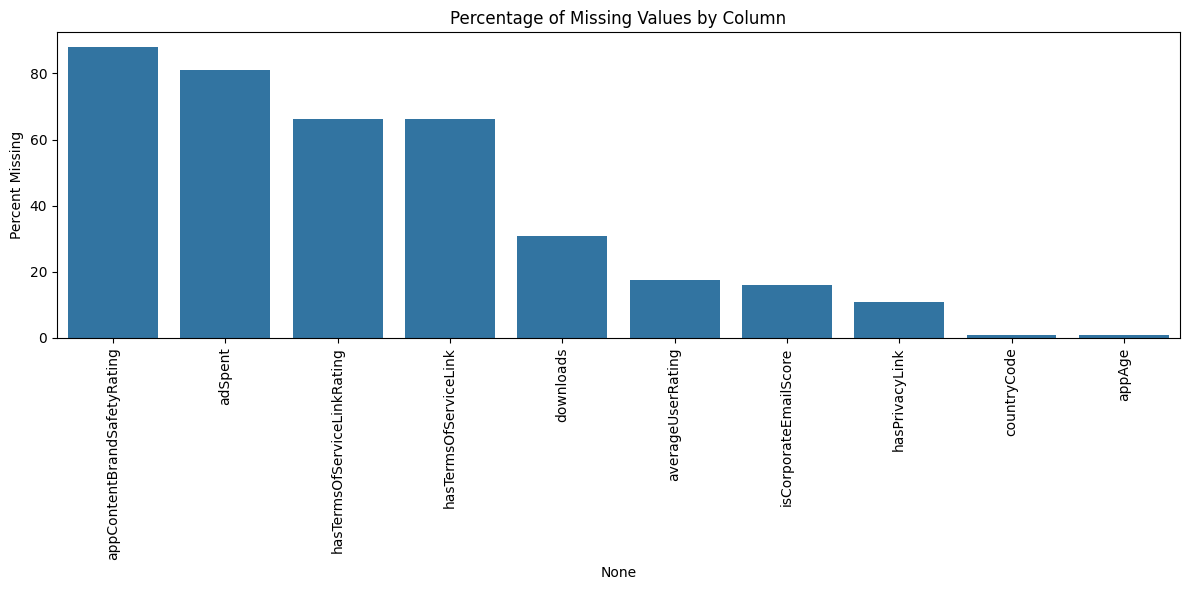

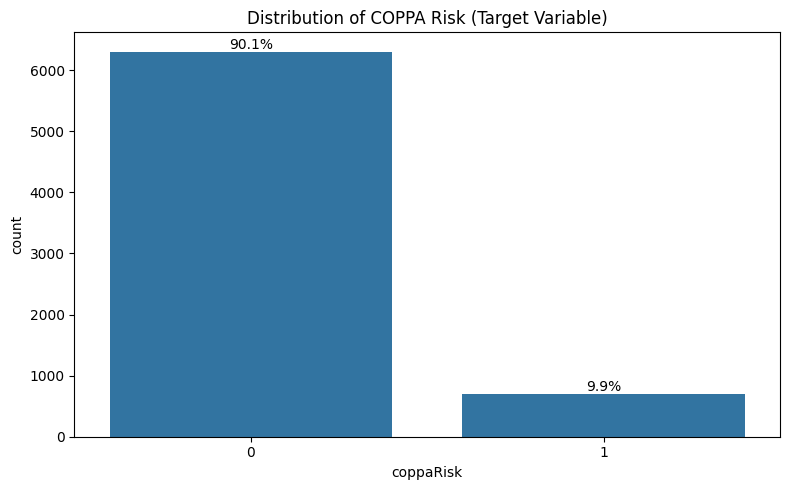


Correlation matrix with target:
coppaRisk_numeric        1.000000
averageUserRating        0.080839
userRatingCount          0.065432
isCorporateEmailScore    0.040421
adSpent                  0.032149
appAge                  -0.000458
Name: coppaRisk_numeric, dtype: float64


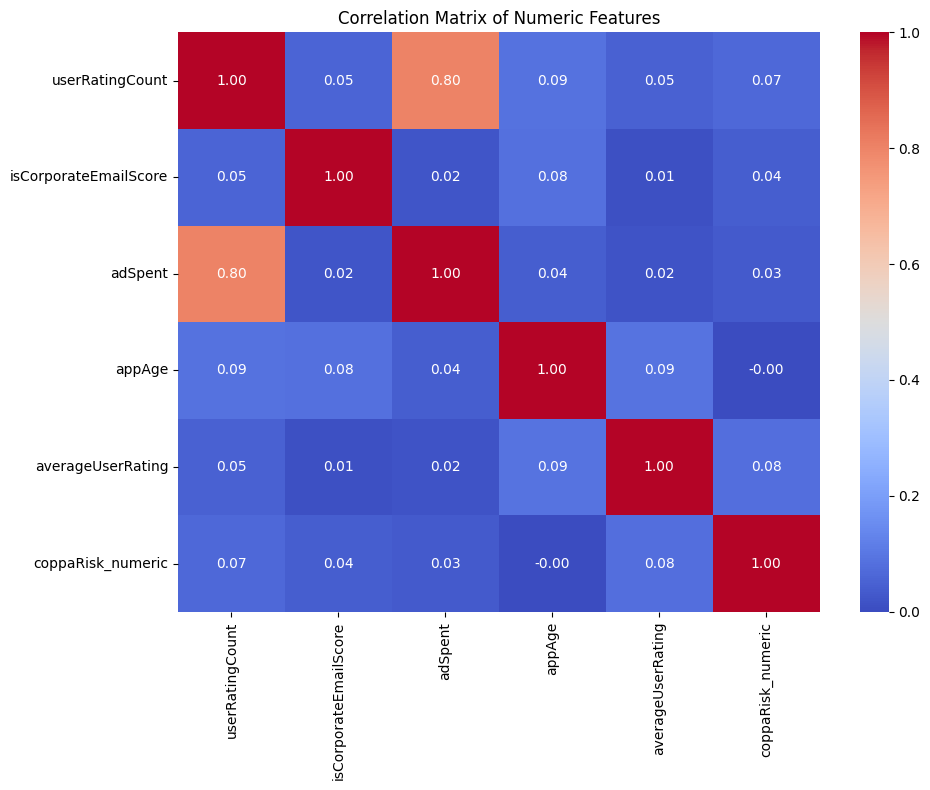

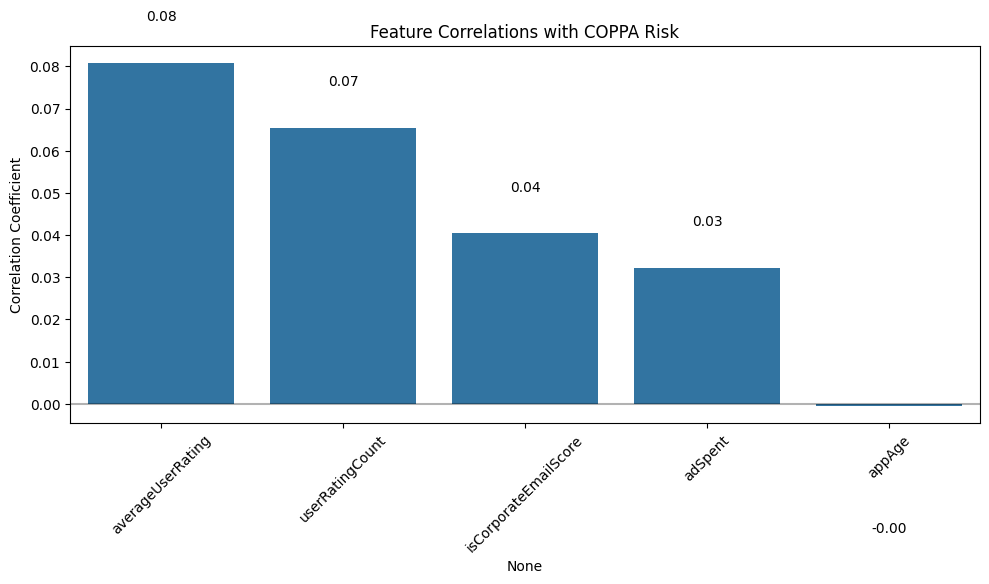


COPPA risk rate by genre (min 20 apps):
                  count       mean
primaryGenreName                  
Education           500  37.600000
Stickers             20  25.000000
Games              1828  23.468271
Reference            21  14.285714
Entertainment       431  11.368910
Sports               54   5.555556
Art & Design         42   4.761905
Travel               60   3.333333
Photo & Video        34   2.941176
Music                36   2.777778


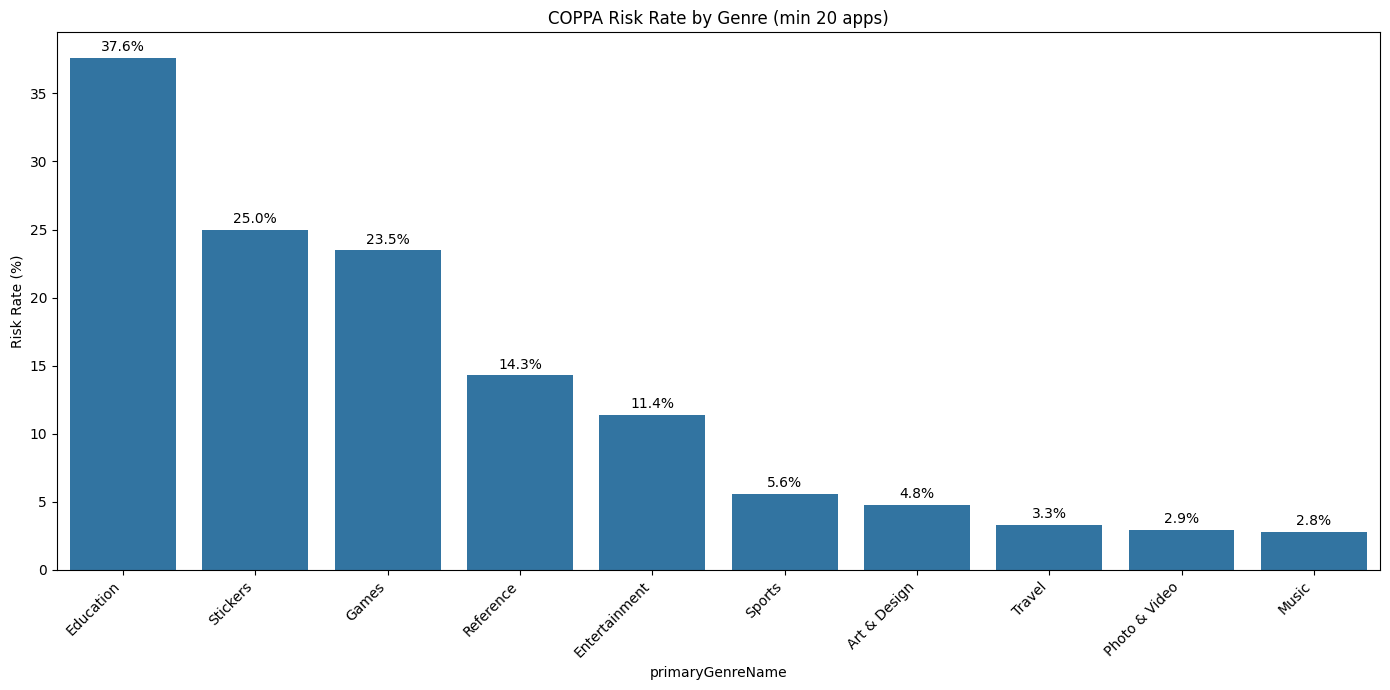


COPPA risk by privacy policy presence:
                count       mean
hasPrivacyLink                  
False              61   4.918033
True             6189  10.340927


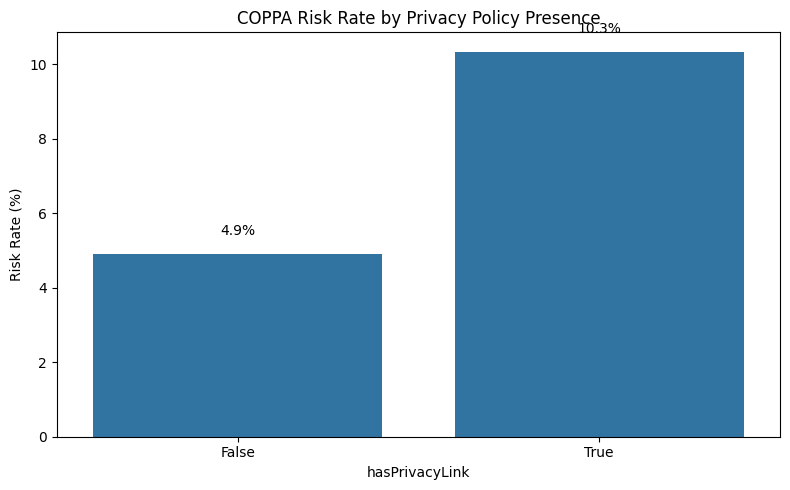

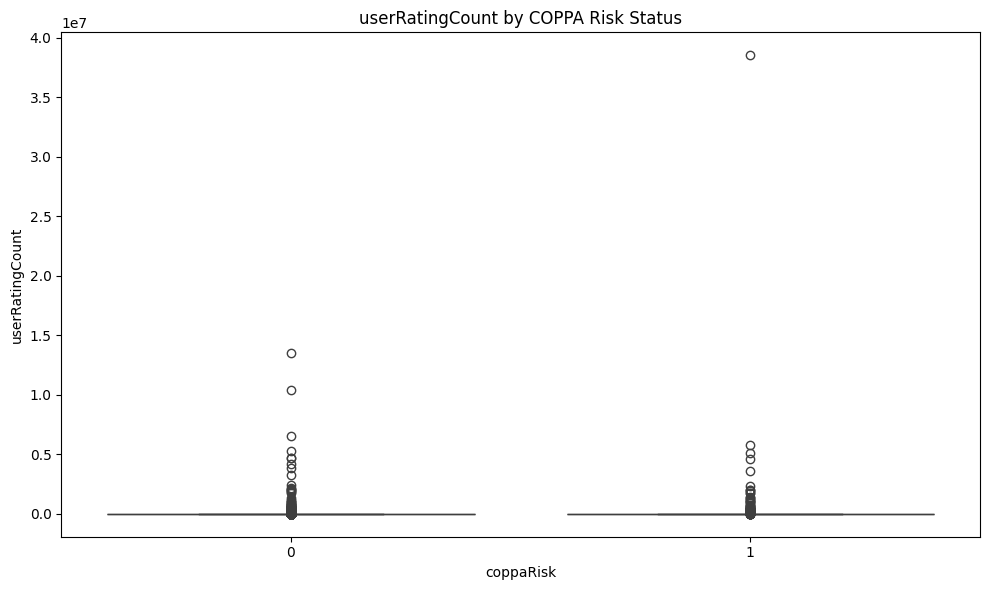

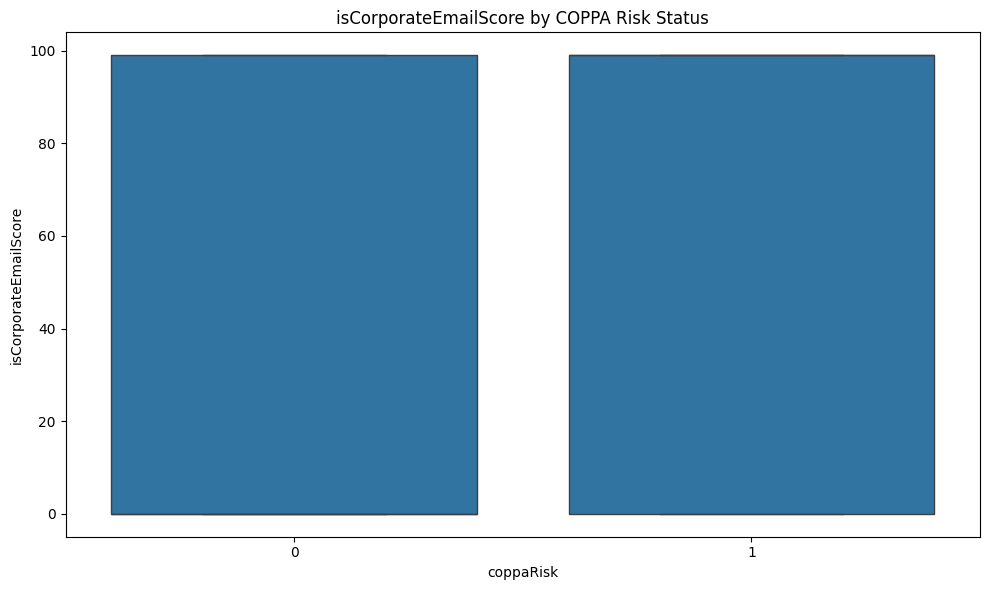

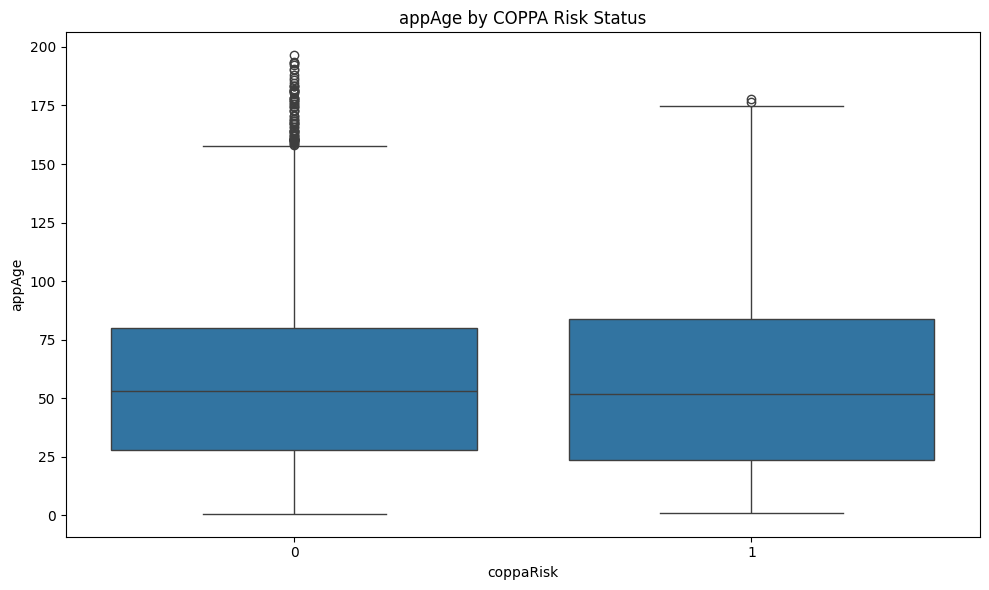

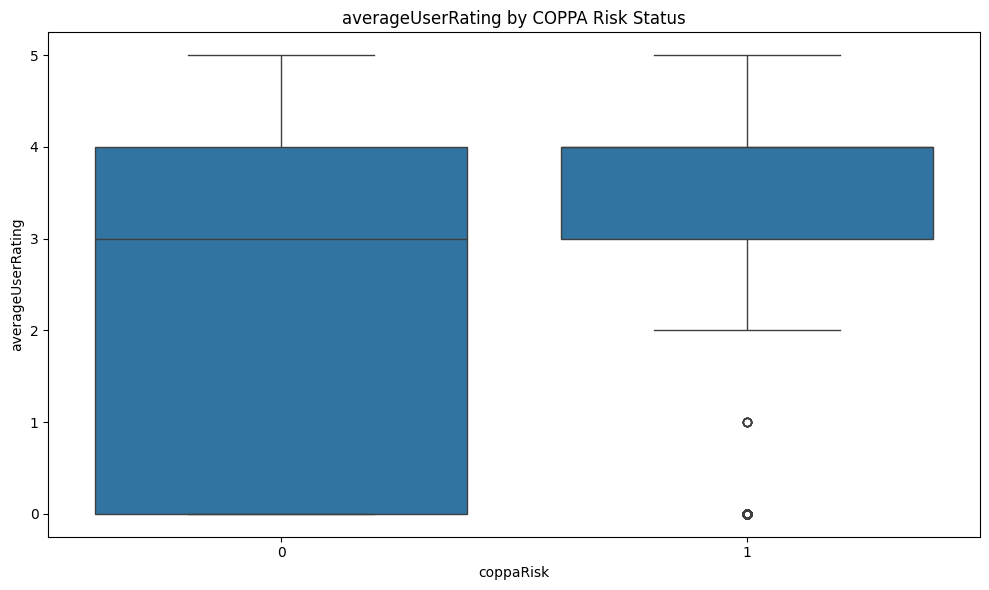

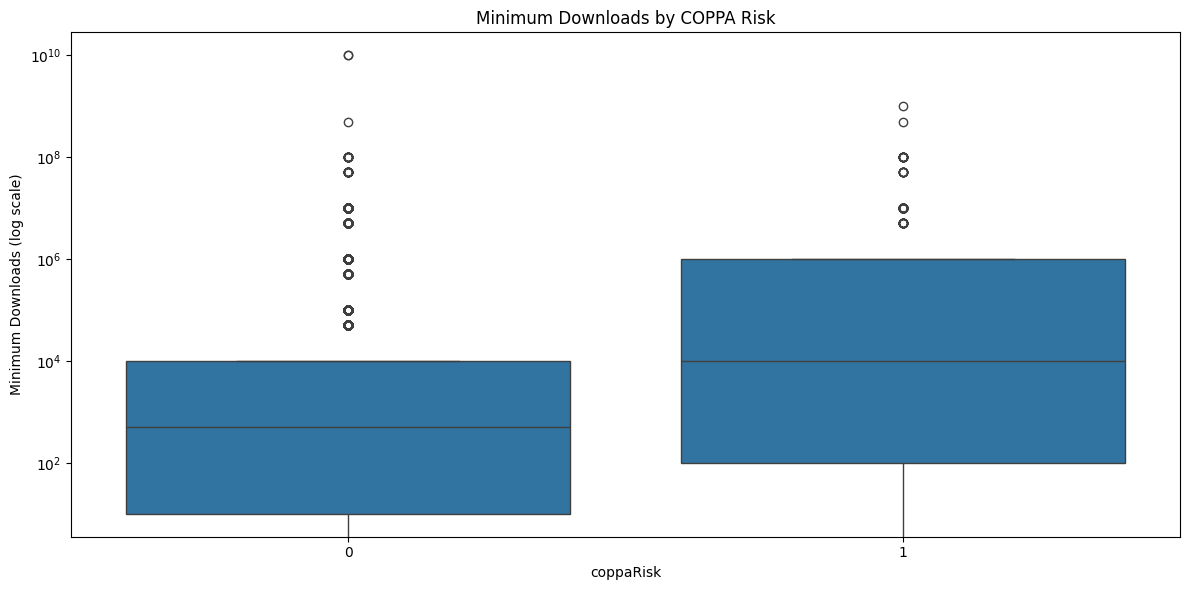

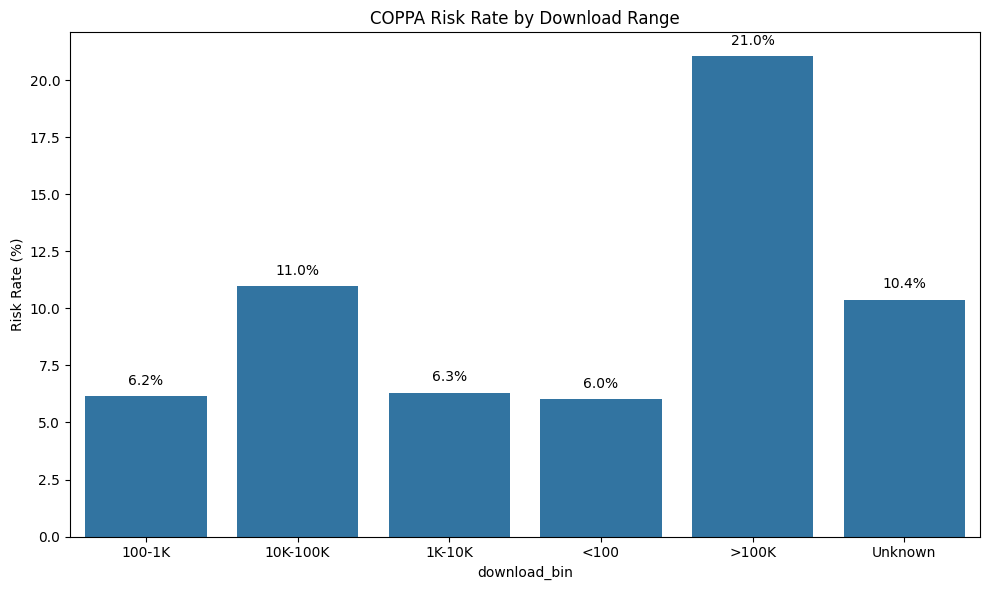

In [83]:
# Make sure we're correctly interpreting the target variable
# Check unique values first
print("Unique values in coppaRisk column:", train['coppaRisk'].unique())

# Convert to numeric properly
train['coppaRisk_numeric'] = (train['coppaRisk'] == True).astype(int)

# Verify our conversion worked
print("\nTarget distribution after conversion:")
print(train['coppaRisk_numeric'].value_counts())
print(f"Percentage of True: {100 * train['coppaRisk_numeric'].mean():.2f}%")

# 1. Missing values visualization
missing = train.isnull().sum().sort_values(ascending=False)
missing_percent = 100 * missing / len(train)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=missing_df.index, y='Missing Percent', data=missing_df)
plt.title('Percentage of Missing Values by Column')
plt.xticks(rotation=90)
plt.ylabel('Percent Missing')
plt.tight_layout()
plt.show()

# 2. Target variable distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='coppaRisk', data=train)
plt.title('Distribution of COPPA Risk (Target Variable)')

# Add percentage labels
total = len(train)
for i, p in enumerate(ax.patches):
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 3. Correlation matrix - fixed to show all correlations including target
numeric_cols = ['userRatingCount', 'isCorporateEmailScore', 'adSpent', 'appAge', 'averageUserRating']
# Add target to the list
cols_with_target = numeric_cols + ['coppaRisk_numeric']

# Fill missing values for correlation calculation only
corr_df = train[cols_with_target].copy()
for col in numeric_cols:
    corr_df[col] = corr_df[col].fillna(corr_df[col].median())

corr_matrix = corr_df.corr()
print("\nCorrelation matrix with target:")
print(corr_matrix['coppaRisk_numeric'].sort_values(ascending=False))

# Plot full correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# 4. Bar chart of feature correlations with target
plt.figure(figsize=(10, 6))
target_corrs = corr_matrix['coppaRisk_numeric'].drop('coppaRisk_numeric').sort_values(ascending=False)
ax = sns.barplot(x=target_corrs.index, y=target_corrs.values)
plt.title('Feature Correlations with COPPA Risk')
plt.xticks(rotation=45)
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add correlation values as text
for i, v in enumerate(target_corrs.values):
    ax.text(i, v + 0.01 if v >= 0 else v - 0.03, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

# 5. Genre vs COPPA risk - FIXED
# Calculate risk rate by genre properly
genre_risk = train.groupby('primaryGenreName')['coppaRisk_numeric'].agg(['count', 'mean'])
genre_risk = genre_risk[genre_risk['count'] >= 20]  # Min 20 apps per genre
genre_risk = genre_risk.sort_values('mean', ascending=False)
genre_risk['mean'] = genre_risk['mean'] * 100  # Convert to percentage

print("\nCOPPA risk rate by genre (min 20 apps):")
print(genre_risk.head(10))

plt.figure(figsize=(14, 7))
ax = sns.barplot(x=genre_risk.index[:10], y='mean', data=genre_risk[:10])
plt.title('COPPA Risk Rate by Genre (min 20 apps)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Risk Rate (%)')

# Add percentage labels
for i, v in enumerate(genre_risk['mean'][:10]):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

# 6. Privacy policy vs COPPA risk - FIXED
privacy_risk = train.groupby('hasPrivacyLink')['coppaRisk_numeric'].agg(['count', 'mean'])
privacy_risk['mean'] = privacy_risk['mean'] * 100  # Convert to percentage

print("\nCOPPA risk by privacy policy presence:")
print(privacy_risk)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=privacy_risk.index, y='mean', data=privacy_risk)
plt.title('COPPA Risk Rate by Privacy Policy Presence')
plt.ylabel('Risk Rate (%)')

# Add percentage labels
for i, v in enumerate(privacy_risk['mean']):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

# 7. Box plots for key numerical features
for col in ['userRatingCount', 'isCorporateEmailScore', 'appAge', 'averageUserRating']:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(x='coppaRisk', y=col, data=train)
    plt.title(f'{col} by COPPA Risk Status')
    # For very skewed features, use log scale
    if train[col].skew() > 5 and (train[col] > 0).all():
        plt.yscale('log')
        plt.ylabel(f'{col} (log scale)')
    plt.tight_layout()
    plt.show()

# 8. Distribution of downloads (min range)
if 'downloads' in train.columns:
    # Extract minimum downloads from the range
    def extract_min(downloads_str):
        if pd.isna(downloads_str):
            return np.nan
        try:
            return int(downloads_str.split(' - ')[0])
        except:
            return np.nan

    train['min_downloads'] = train['downloads'].apply(extract_min)

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x='coppaRisk', y='min_downloads', data=train)
    plt.title('Minimum Downloads by COPPA Risk')
    plt.yscale('log')
    plt.ylabel('Minimum Downloads (log scale)')
    plt.tight_layout()
    plt.show()

    # Calculate COPPA risk by download range (binned)
    def categorize_downloads(min_val):
        if pd.isna(min_val):
            return 'Unknown'
        elif min_val < 100:
            return '<100'
        elif min_val < 1000:
            return '100-1K'
        elif min_val < 10000:
            return '1K-10K'
        elif min_val < 100000:
            return '10K-100K'
        else:
            return '>100K'

    train['download_bin'] = train['min_downloads'].apply(categorize_downloads)

    download_risk = train.groupby('download_bin')['coppaRisk_numeric'].agg(['count', 'mean'])
    download_risk = download_risk[download_risk['count'] >= 20]
    download_risk['mean'] = download_risk['mean'] * 100

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=download_risk.index, y='mean', data=download_risk)
    plt.title('COPPA Risk Rate by Download Range')
    plt.ylabel('Risk Rate (%)')

    # Add percentage labels
    for i, v in enumerate(download_risk['mean']):
        ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')

    plt.tight_layout()
    plt.show()

In [84]:
# only use for visualization
train = train.drop(['download_bin', 'coppaRisk_numeric','min_downloads'], axis=1, errors='ignore')

## 1. Split Training & Validation Set

In [85]:
from sklearn.model_selection import  train_test_split

train_set, val_set = train_test_split(train, stratify=train['coppaRisk'], test_size=0.2, random_state=42)

## 2. Data Cleaning & Preprocessing

### A. Data Cleaning

In [86]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

#### I. Handling Missing Data

In [87]:
def analyze_imputation_strategies(df, verbose=True):
    """
    Analyze each feature in the dataframe and recommend appropriate imputation strategies.

    Parameters:
    -----------
    df : pandas DataFrame
        The dataset to analyze
    verbose : bool, default=True
        Whether to print detailed analysis

    Returns:
    --------
    dict
        Dictionary with column names as keys and recommended strategies as values
    """
    # Dictionary to store recommended strategies
    recommended_strategies = {}

    # Function to print section headers for readability
    def print_section(title):
        if verbose:
            print("\n" + "="*50)
            print(title)
            print("="*50)

    print_section("ANALYZING IMPUTATION STRATEGIES")

    # Analyze each column
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        missing_percent = 100 * missing_count / len(df)

        # Skip columns with no missing values
        if missing_count == 0:
            recommended_strategies[column] = 'no_missing_values'
            if verbose:
                print(f"\n{column}: No missing values")
            continue

        # Handle columns with very high missing percentages
        if missing_percent > 50:
            recommended_strategies[column] = 'drop_column'
            if verbose:
                print(f"\n{column}: HIGH MISSING DATA ({missing_percent:.2f}%)")
                print(f"  - Recommendation: Drop column")
            continue

        # Check column type
        col_type = df[column].dtype

        if verbose:
            print(f"\n{column}: {missing_count} missing values ({missing_percent:.2f}%)")
            print(f"  - Data type: {col_type}")

        # For numeric columns
        if np.issubdtype(col_type, np.number):
            # Calculate statistics
            non_missing = df[column].dropna()

            if len(non_missing) == 0:
                recommended_strategies[column] = 'drop_column'
                if verbose:
                    print(f"  - All values are missing")
                    print(f"  - Recommendation: Drop column")
                continue

            mean_val = non_missing.mean()
            median_val = non_missing.median()
            mode_val = non_missing.mode()[0]
            skew = non_missing.skew()

            if verbose:
                print(f"  - Mean: {mean_val:.4f}")
                print(f"  - Median: {median_val:.4f}")
                print(f"  - Mode: {mode_val}")
                print(f"  - Skewness: {skew:.4f}")

            # Check distribution
            if abs(skew) > 1:
                # For skewed distributions, median is usually better
                recommended_strategies[column] = 'median'
                if verbose:
                    print(f"  - Recommendation: Median imputation (skewed distribution)")
            else:
                # For normal distributions, mean might be better
                recommended_strategies[column] = 'mean'
                if verbose:
                    print(f"  - Recommendation: Mean imputation (normal distribution)")

            # Special case for userRatingCount or similar metrics that might be 0 by design
            if 'count' in column.lower() and median_val == 0:
                recommended_strategies[column] = 'constant_0'
                if verbose:
                    print(f"  - Special recommendation: Constant 0 (count-like variable)")

        # For categorical columns
        elif pd.api.types.is_object_dtype(col_type) or pd.api.types.is_bool_dtype(col_type):
            # Get value counts
            value_counts = df[column].value_counts(normalize=True, dropna=False)
            top_values = value_counts.head(3)

            if verbose:
                print(f"  - Value distribution (top 3):")
                for val, freq in top_values.items():
                    if pd.isna(val):
                        continue
                    print(f"      {val}: {freq*100:.2f}%")

            # Special handling for developerCountry
            if column == 'developerCountry':
                # If the column contains placeholder values for missing information
                if any(val in ['ADDRESS NOT LISTED IN PLAYSTORE', 'CANNOT IDENTIFY COUNTRY']
                      for val in df[column].unique()):
                    recommended_strategies[column] = 'custom_placeholder'
                    if verbose:
                        print(f"  - Special recommendation: Use 'UNKNOWN' (already contains placeholder values)")

            # Check if a value is highly dominant
            elif value_counts.iloc[0] > 0.8:
                recommended_strategies[column] = 'most_frequent'
                if verbose:
                    print(f"  - Recommendation: Most frequent imputation (dominant category)")
            else:
                # For more balanced distributions, still use most frequent but note it
                recommended_strategies[column] = 'most_frequent'
                if verbose:
                    print(f"  - Recommendation: Most frequent imputation")

            # Special case for boolean-like features
            if len(value_counts) == 2:
                if verbose:
                    print(f"  - Note: Binary feature - most frequent imputation suitable")

        # Handle special columns
        if column == 'downloads':
            recommended_strategies[column] = 'custom_downloads'
            if verbose:
                print(f"  - Special recommendation: Custom handling for downloads range")

    # Summarize recommendations
    print_section("SUMMARY OF RECOMMENDATIONS")
    strategy_counts = {}

    for col, strategy in recommended_strategies.items():
        if strategy not in strategy_counts:
            strategy_counts[strategy] = 0
        strategy_counts[strategy] += 1

        if verbose:
            print(f"{col}: {strategy}")

    if verbose:
        print("\nStrategy distribution:")
        for strategy, count in strategy_counts.items():
            print(f"  {strategy}: {count} columns")

    return recommended_strategies

In [88]:
class FeatureCleaner(BaseEstimator, TransformerMixin):
    """
    Handle missing data with adaptive strategies for each column
    """
    def __init__(self, analyze_first=True, create_indicators=True, process_downloads=True):
        self.analyze_first = analyze_first
        self.create_indicators = create_indicators
        self.process_downloads = process_downloads
        self.strategy_dict = {}

    def _preprocess_developer_country(self, X):
        """
        Process developerCountry column to handle placeholder values
        """
        X = X.copy()

        if 'developerCountry' in X.columns:
            # Define placeholder values that indicate missing information
            placeholder_values = ['ADDRESS NOT LISTED IN PLAYSTORE', 'CANNOT IDENTIFY COUNTRY']

            # Create a binary feature indicating if location is missing
            X['is_country_missing'] = X['developerCountry'].isin(placeholder_values).astype(int)

            # Group placeholder values into a single category
            X['developerCountry'] = X['developerCountry'].replace(
                placeholder_values, 'UNKNOWN_LOCATION')

        return X

    def _process_downloads(self, df):
        """
        Process download ranges into min, max, and category
        """
        result_df = df.copy()

        def extract_min_max(download_str):
            if pd.isna(download_str):
                return np.nan, np.nan
            try:
                parts = download_str.split(' - ')
                if len(parts) == 2:
                    val1 = int(parts[0])
                    val2 = int(parts[1])
                    # make sure min is always smaller value
                    min_val = min(val1, val2)
                    max_val = max(val1, val2)
                    return min_val, max_val
                else:
                    return np.nan, np.nan
            except:
                return np.nan, np.nan

        # Apply extraction and create new columns
        result_df['min_downloads'] = result_df['downloads'].apply(lambda x: extract_min_max(x)[0] if not pd.isna(x) else np.nan)
        result_df['max_downloads'] = result_df['downloads'].apply(lambda x: extract_min_max(x)[1] if not pd.isna(x) else np.nan)
        result_df['avg_downloads'] = (result_df['min_downloads'] + result_df['max_downloads']) / 2

        def categorize_downloads(min_val):
            if pd.isna(min_val):
                return 'Unknown'
            elif min_val < 100:
                return '<100'
            elif min_val < 1000:
                return '100-1K'
            elif min_val < 10000:
                return '1K-10K'
            elif min_val < 100000:
                return '10K-100K'
            else:
                return '>100K'

        result_df['download_category'] = result_df['min_downloads'].apply(categorize_downloads)
        result_df = result_df.drop(columns=['downloads'])
        self.download_cols_ = ['min_downloads', 'max_downloads', 'avg_downloads']
        return result_df

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()

        # Preprocess developerCountry first
        X = self._preprocess_developer_country(X)

        # Process downloads if requested
        if self.process_downloads and 'downloads' in X.columns:
            X = self._process_downloads(X)

            # Update strategy for new download columns
            if hasattr(self, 'download_cols_'):
                for col in self.download_cols_:
                    self.strategy_dict[col] = 'median'

        # Analyze imputation strategies if requested
        if self.analyze_first:
            self.strategy_dict = analyze_imputation_strategies(X, verbose=True)

        # Separate numeric and categorical columns
        self.numeric_cols_ = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
        self.categorical_cols_ = X.select_dtypes(include=['object', 'bool']).columns.tolist()

        # Get columns to drop (high missing %)
        self.cols_to_drop_ = [col for col, strategy in self.strategy_dict.items()
                             if strategy == 'drop_column']

        # Remove drop columns from imputation lists
        for col in self.cols_to_drop_:
            if col in self.numeric_cols_:
                self.numeric_cols_.remove(col)
            elif col in self.categorical_cols_:
                self.categorical_cols_.remove(col)

        # Create imputers for each type
        self.mean_imputer_ = SimpleImputer(strategy='mean')
        self.median_imputer_ = SimpleImputer(strategy='median')
        self.cat_imputer_ = SimpleImputer(strategy='most_frequent')

        # Split columns by strategy
        self.mean_cols_ = [col for col in self.numeric_cols_ if self.strategy_dict.get(col) == 'mean']
        self.median_cols_ = [col for col in self.numeric_cols_ if col not in self.mean_cols_]

        # Fit imputers
        if self.mean_cols_:
            self.mean_imputer_.fit(X[self.mean_cols_])
        if self.median_cols_:
            self.median_imputer_.fit(X[self.median_cols_])
        if self.categorical_cols_:
            self.cat_imputer_.fit(X[self.categorical_cols_])

        # Track columns with missing values for indicators
        if self.create_indicators:
            self.missing_cols_ = [col for col in X.columns
                                 if X[col].isnull().sum() > 0
                                 and col not in self.cols_to_drop_]

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        # Preprocess developerCountry first
        X = self._preprocess_developer_country(X)

        # Process downloads
        if self.process_downloads and 'downloads' in X.columns:
            X = self._process_downloads(X)

        # Create missing indicators
        if self.create_indicators and hasattr(self, 'missing_cols_'):
            for col in self.missing_cols_:
                if col in X.columns:
                    X[f'{col}_missing'] = X[col].isnull().astype(int)

        # Apply special case for constant 0 imputation
        for col in self.numeric_cols_:
            if col in X.columns and self.strategy_dict.get(col) == 'constant_0':
                X[col] = X[col].fillna(0)

        # Apply mean imputation
        mean_cols_present = [col for col in self.mean_cols_ if col in X.columns]
        if mean_cols_present:
            X[mean_cols_present] = self.mean_imputer_.transform(X[mean_cols_present])

        # Apply median imputation
        median_cols_present = [col for col in self.median_cols_ if col in X.columns]
        if median_cols_present:
            X[median_cols_present] = self.median_imputer_.transform(X[median_cols_present])

        # Apply categorical imputation
        cat_cols_present = [col for col in self.categorical_cols_ if col in X.columns]
        if cat_cols_present:
            X[cat_cols_present] = self.cat_imputer_.transform(X[cat_cols_present])

        # Special handling for custom strategies (formerly in AdaptiveImputer)
        for col, strategy in self.strategy_dict.items():
            if col not in X.columns:
                continue

            if strategy == 'custom_placeholder' and pd.isna(X[col]).any():
                X[col] = X[col].fillna('UNKNOWN')

        # Drop columns with high missing %
        X = X.drop(columns=self.cols_to_drop_, errors='ignore')

        return X

In [89]:
# ? testing
# analyze_imputation_strategies(train)

#### II. Dealing with Outliers

In [90]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer

In [91]:
class FeatureTransformator(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0, target_column='coppaRisk'):

        self.skew_threshold = skew_threshold
        self.target_column = target_column
        
        self.log1p_cols_ = []
        self.power_transformers_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()
        for col in X.select_dtypes(include=[np.number]).columns:
            if col == self.target_column:
                continue

            skewness = X[col].skew()
            if abs(skewness) > self.skew_threshold:
                if skewness > 0:
                    self.log1p_cols_.append(col)
                else:
                    pt = PowerTransformer(method='yeo-johnson')
                    
                    pt.fit(X[col].values.reshape(-1, 1))
                    
                    self.power_transformers_[col] = pt
        
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        
        for col in self.log1p_cols_:
            if col in X.columns:
                X[col] = np.log1p(X[col])

        for col, pt in self.power_transformers_.items():
            if col in X.columns:
                X[col] = pt.transform(X[col].values.reshape(-1, 1)).flatten()

        return X


#### III. Remove Duplicates

In [92]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False):
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        before_len = len(X)
        X.drop_duplicates(inplace=True)
        after_len = len(X)
        X.reset_index(drop=True, inplace=True)

        if self.verbose:
            print(f"Before dropping duplicates: {before_len}")
            print(f"After dropping duplicates:  {after_len}")

        return X


#### IV. Feature Engineering

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureDropper(BaseEstimator, TransformerMixin):
    """
    Drops a predefined list of features.

    Parameters:
    -----------
    cols_to_drop : list of str, optional (default=None)
        A list of column names to drop explicitly.

    verbose : bool, optional (default=True)
        If True, prints the columns being dropped.
    """
    def __init__(self, cols_to_drop=None, verbose=True):
        # Store the list of columns to drop provided during initialization
        self.cols_to_drop = cols_to_drop if cols_to_drop is not None else []
        self.verbose = verbose
        # This attribute will store the final list after fit (which is just self.cols_to_drop)
        self.final_cols_to_drop_ = []

    def fit(self, X, y=None):
        """
        Stores the list of columns to be dropped.

        Parameters:
        -----------
        X : pd.DataFrame
            Input features (used to check column existence, but not for calculations).
        y : pd.Series or np.array, optional
            Target variable (ignored).

        Returns:
        --------
        self : object
            Returns the instance itself.
        """
        # Simply assign the predefined list
        self.final_cols_to_drop_ = self.cols_to_drop

        if self.verbose:
            print(f"FeatureDropper initialized to drop: {sorted(self.final_cols_to_drop_)}")

        return self

    def transform(self, X):
        """
        Drops the specified columns from the DataFrame.

        Parameters:
        -----------
        X : pd.DataFrame
            Input features.

        Returns:
        --------
        pd.DataFrame
            DataFrame with specified columns dropped.
        """
        X_ = X.copy()

        # Check if fit has been called (although fit is very simple now)
        if not hasattr(self, 'final_cols_to_drop_'):
             raise RuntimeError("This FeatureDropper instance is not fitted yet. Call 'fit' before using 'transform'.")

        # Identify which columns to drop are actually present in X
        cols_present_to_drop = [col for col in self.final_cols_to_drop_ if col in X_.columns]

        if not cols_present_to_drop:
             if self.verbose:
                 print("FeatureDropper: No columns from the drop list found in the input DataFrame.")
             return X_

        if self.verbose:
            # Only print if transform is actually dropping something
            if cols_present_to_drop:
                 print(f"FeatureDropper: Dropping columns: {sorted(cols_present_to_drop)}")

        X_ = X_.drop(columns=cols_present_to_drop, errors='ignore')
        return X_


In [ ]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Creates new features based on EDA insights and potential interactions.

    Assumes it runs after FeatureCleaner (which handles missing values and downloads)
    and potentially after FeatureDropper.
    """
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.new_feature_names_ = [] # To keep track of created features

    def fit(self, X, y=None):
        # This transformer doesn't learn parameters from data, just applies rules.
        # However, we can list the features it intends to create here.
        self.new_feature_names_ = [
            'is_genre_education',
            'is_genre_games',
            'is_device_mobile',
            'weighted_user_rating',
            'rating_x_avg_downloads',
            'has_both_links_post_impute', # Assumes cleaner imputed missing bools
            'desc_safety_low',
            'is_dev_country_unknown' # From FeatureCleaner's preprocessing
        ]
        if self.verbose:
            print(f"FeatureCreator initialized. Will attempt to create: {self.new_feature_names_}")
        return self

    def transform(self, X):
        """
        Applies the feature creation logic.

        Parameters:
        -----------
        X : pd.DataFrame
            Input features. Should have columns processed by previous steps
            (e.g., FeatureCleaner).

        Returns:
        --------
        pd.DataFrame
            DataFrame with new features added.
        """
        X_ = X.copy()
        created_features = []

        # 1. Genre Flags (based on higher risk rates)
        if 'primaryGenreName' in X_.columns:
            X_['is_genre_education'] = (X_['primaryGenreName'] == 'Education').astype(int)
            X_['is_genre_games'] = (X_['primaryGenreName'] == 'Games').astype(int)
            created_features.extend(['is_genre_education', 'is_genre_games'])
            if self.verbose: print("  - Created genre flags: is_genre_education, is_genre_games")

        # 2. Device Type Flag (Mobile focus)
        if 'deviceType' in X_.columns:
            X_['is_device_mobile'] = X_['deviceType'].isin(['smartphone', 'tablet']).astype(int)
            created_features.append('is_device_mobile')
            if self.verbose: print("  - Created device flag: is_device_mobile")

        # 3. Weighted User Rating (Interaction)
        #    Assumes 'userRatingCount' and 'averageUserRating' exist and are cleaned/imputed
        if 'userRatingCount' in X_.columns and 'averageUserRating' in X_.columns:
            # Ensure columns are numeric, coerce errors just in case
            count_col = pd.to_numeric(X_['userRatingCount'], errors='coerce').fillna(0)
            rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
            X_['weighted_user_rating'] = count_col * rating_col
            created_features.append('weighted_user_rating')
            if self.verbose: print("  - Created interaction: weighted_user_rating")

        # 4. Rating x Downloads Interaction
        #    Assumes 'averageUserRating' and 'avg_downloads' (from FeatureCleaner) exist
        if 'averageUserRating' in X_.columns and 'avg_downloads' in X_.columns:
             # Ensure columns are numeric
            rating_col = pd.to_numeric(X_['averageUserRating'], errors='coerce').fillna(0)
            downloads_col = pd.to_numeric(X_['avg_downloads'], errors='coerce').fillna(0)
            X_['rating_x_avg_downloads'] = rating_col * downloads_col
            created_features.append('rating_x_avg_downloads')
            if self.verbose: print("  - Created interaction: rating_x_avg_downloads")

        # 5. Link Presence Interaction (Post-Imputation)
        #    Assumes FeatureCleaner imputed missing booleans (likely with most frequent)
        #    and FeatureEncoder will handle True/False -> 1/0 later.
        #    We create this based on the state *after* imputation but *before* encoding.
        if 'hasPrivacyLink' in X_.columns and 'hasTermsOfServiceLink' in X_.columns:
            # Convert to boolean robustly, treating non-True as False for the check
            has_privacy = X_['hasPrivacyLink'].apply(lambda x: x is True)
            has_tos = X_['hasTermsOfServiceLink'].apply(lambda x: x is True)
            X_['has_both_links_post_impute'] = (has_privacy & has_tos).astype(int)
            created_features.append('has_both_links_post_impute')
            if self.verbose: print("  - Created link flag: has_both_links_post_impute")

        # 6. Description Safety Rating Flag (Highest risk category)
        if 'appDescriptionBrandSafetyRating' in X_.columns:
            X_['desc_safety_low'] = (X_['appDescriptionBrandSafetyRating'] == 'low').astype(int)
            created_features.append('desc_safety_low')
            if self.verbose: print("  - Created safety flag: desc_safety_low")

        # 7. Developer Country Unknown Flag (Leveraging FeatureCleaner's work)
        #    FeatureCleaner creates 'is_country_missing' and replaces placeholders with 'UNKNOWN_LOCATION'
        #    Let's just use the 'is_country_missing' flag directly if it exists.
        if 'is_country_missing' in X_.columns:
             X_['is_dev_country_unknown'] = X_['is_country_missing'] # Rename for clarity if desired, or just use it
             created_features.append('is_dev_country_unknown')
             if self.verbose: print("  - Added flag: is_dev_country_unknown (from FeatureCleaner)")
        elif 'developerCountry' in X_.columns:
             # Fallback if is_country_missing wasn't created but UNKNOWN_LOCATION was
             X_['is_dev_country_unknown'] = (X_['developerCountry'] == 'UNKNOWN_LOCATION').astype(int)
             created_features.append('is_dev_country_unknown')
             if self.verbose: print("  - Created flag: is_dev_country_unknown (based on UNKNOWN_LOCATION)")


        # Update the list of actually created features
        self.new_feature_names_ = created_features

        if self.verbose:
            print(f"FeatureCreator transform finished. Added columns: {self.new_feature_names_}")

        return X_

# --- How to integrate into your pipeline ---
# Place it after cleaning/dropping steps but generally before scaling/encoding,
# especially for interaction terms.

# Example Pipeline Structure:
# from sklearn.pipeline import Pipeline

# cols_to_drop_based_on_eda = ['isCorporateEmailScore', 'adSpent', 'appAge']

# pipe = Pipeline([
#                  ("duplicate_remover", DuplicateRemover(verbose=True)),
#                  ("feature_dropper", FeatureDropper(cols_to_drop=cols_to_drop_based_on_eda, verbose=True)),
#                  ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)),
#                  # *** Add FeatureCreator here ***
#                  ("feature_creator", FeatureCreator(verbose=True)),
#                  ("feature_transformator", FeatureTransformator()), # Handles skewness
#                  ("feature_scaler", FeatureScaler()), # Scales numeric features (including new ones)
#                  ("feature_encoder", FeatureEncoder()) # Encodes categoricals (original and potentially new ones if any were categorical)
#                  ])

# # Then use pipe.fit_transform(train_set) as before

### B. Data Preprocessing

#### I. Feature Scaling

In [93]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler

In [94]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, 
                 outlier_threshold=5.0, 
                 label_col='coppaRisk'):
        self.columns = columns
        self.outlier_threshold = outlier_threshold
        self.label_col = label_col
        self.scaler = RobustScaler()
        
    def _check_outliers_iqr(self, df, col):
        col_Q1 = df[col].quantile(0.25)
        col_Q3 = df[col].quantile(0.75)
        col_IQR = col_Q3 - col_Q1
        
        col_RLB = col_Q1 - 1.5 * col_IQR 
        col_RUB = col_Q3 + 1.5 * col_IQR  
        
        outliers_count = df.loc[(df[col] < col_RLB) | (df[col] > col_RUB), col].shape[0]
        outlier_percent = outliers_count / len(df) * 100.0
        
        return outlier_percent
    
    def fit(self, X, y=None):
        X = pd.DataFrame(X).copy()

        if self.columns is not None:
            self.columns_ = self.columns
        
        else:
            numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            numeric_cols = [col for col in numeric_cols if col != self.label_col]
            
            self.columns_ = []
            for col in numeric_cols:
                outlier_percent = self._check_outliers_iqr(X, col)
                if outlier_percent > self.outlier_threshold:
                    self.columns_.append(col)
        
        if self.columns_:
            self.scaler.fit(X[self.columns_])
        
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        
        if self.columns_:
            X[self.columns_] = self.scaler.transform(X[self.columns_])
        
        return X


#### II. Feature Encoding

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes categorical features using appropriate strategies.

    Strategies:
    - Binary features (2 unique values, excluding NaN): Label Encoding (0/1)
    - Ordinal features (specified): Ordinal Encoding with defined mapping.
    - Low cardinality nominal features (< max_one_hot_features unique values): One-Hot Encoding.
    - High cardinality nominal features (>= max_one_hot_features unique values): Frequency Encoding.
    """
    def __init__(self, max_one_hot_features=15, target_col='coppaRisk'):
        """
        Args:
            max_one_hot_features (int): Maximum number of unique values for One-Hot Encoding.
                                        Features with more unique values will use Frequency Encoding.
            target_col (str): Name of the target column (ignored by the encoder).
        """
        self.max_one_hot_features = max_one_hot_features
        self.target_col = target_col
        self.encoders_ = {}
        self.columns_to_encode_ = []
        self.ordinal_mapping_ = {
            'hasTermsOfServiceLinkRating': ['low', 'medium', 'high'],
            'appContentBrandSafetyRating': ['low', 'medium', 'high'],
            'appDescriptionBrandSafetyRating': ['low', 'medium', 'high'],
            'mfaRating': ['low', 'medium', 'high'],
            # Add other known ordinal columns and their order if applicable
            # 'download_category': ['Unknown', '<100', '100-1K', '1K-10K', '10K-100K', '>100K'] # Example if download_category is treated as ordinal
        }
        self.binary_cols_ = []
        self.ordinal_cols_ = []
        self.one_hot_cols_ = []
        self.frequency_cols_ = []
        self.frequency_maps_ = {}

    def fit(self, X, y=None):
        """
        Identify categorical columns and determine encoding strategy.

        Args:
            X (pd.DataFrame): Input features.
            y (pd.Series, optional): Target variable. Defaults to None.

        Returns:
            self: The fitted encoder instance.
        """
        X_ = X.copy()
        self.columns_to_encode_ = X_.select_dtypes(include=['object', 'bool']).columns.tolist()

        # Remove target column if present
        if self.target_col in self.columns_to_encode_:
            self.columns_to_encode_.remove(self.target_col)

        # Remove columns that might have been added by previous steps but are numeric
        numeric_like_added = [col for col in self.columns_to_encode_ if '_missing' in col or '_processed' in col] # Example suffixes
        self.columns_to_encode_ = [col for col in self.columns_to_encode_ if col not in numeric_like_added]


        for col in self.columns_to_encode_:
            unique_vals = X_[col].dropna().unique()
            n_unique = len(unique_vals)

            # 1. Binary Encoding (for boolean or 2 unique value object columns)
            if X_[col].dtype == 'bool' or (X_[col].dtype == 'object' and n_unique == 2):
                self.binary_cols_.append(col)
                le = LabelEncoder()
                # Fit LabelEncoder only on non-NaN values, handle NaN during transform
                le.fit(X_[col].dropna())
                self.encoders_[col] = le
                print(f"'{col}': Binary Encoding (LabelEncoder)")

            # 2. Ordinal Encoding (based on predefined mapping)
            elif col in self.ordinal_mapping_:
                self.ordinal_cols_.append(col)
                mapping = self.ordinal_mapping_[col]
                oe = OrdinalEncoder(categories=[mapping], handle_unknown='use_encoded_value', unknown_value=np.nan) # Handle potential NaNs or unseen values
                # Fit requires 2D array
                oe.fit(X_[[col]])
                self.encoders_[col] = oe
                print(f"'{col}': Ordinal Encoding")

            # 3. One-Hot Encoding (low cardinality nominal)
            elif n_unique < self.max_one_hot_features:
                self.one_hot_cols_.append(col)
                # handle_unknown='ignore' drops unseen categories during transform
                ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                # Fit requires 2D array
                ohe.fit(X_[[col]].fillna('Missing')) # Temporarily fillna for fitting OHE
                self.encoders_[col] = ohe
                print(f"'{col}': One-Hot Encoding (Unique values: {n_unique})")

            # 4. Frequency Encoding (high cardinality nominal)
            else:
                self.frequency_cols_.append(col)
                # Calculate frequency map (relative frequency)
                freq_map = (X_[col].value_counts(normalize=True)).to_dict()
                self.frequency_maps_[col] = freq_map
                print(f"'{col}': Frequency Encoding (Unique values: {n_unique})")

        self.fitted_ = True
        return self

    def transform(self, X):
        """
        Apply the learned encoding transformations.

        Args:
            X (pd.DataFrame): Input features.

        Returns:
            pd.DataFrame: Transformed DataFrame with encoded features.
        """
        if not hasattr(self, 'fitted_'):
            raise RuntimeError("Transformer is not fitted yet.")

        X_ = X.copy()

        # Apply Binary Encoding
        for col in self.binary_cols_:
            if col in X_.columns:
                le = self.encoders_[col]
                # Transform non-NaN values, keep NaNs as NaNs
                non_nan_mask = X_[col].notna()
                X_.loc[non_nan_mask, col] = le.transform(X_.loc[non_nan_mask, col])
                X_[col] = pd.to_numeric(X_[col], errors='coerce') # Ensure numeric type, NaNs remain

        # Apply Ordinal Encoding
        for col in self.ordinal_cols_:
             if col in X_.columns:
                oe = self.encoders_[col]
                # OrdinalEncoder expects 2D array
                encoded_data = oe.transform(X_[[col]])
                X_[col] = encoded_data.flatten() # Flatten back to 1D Series

        # Apply Frequency Encoding
        for col in self.frequency_cols_:
             if col in X_.columns:
                freq_map = self.frequency_maps_[col]
                # Map values, use 0 for unseen values (or NaN if preferred)
                X_[col] = X_[col].map(freq_map).fillna(0)

        # Apply One-Hot Encoding
        for col in self.one_hot_cols_:
             if col in X_.columns:
                ohe = self.encoders_[col]
                # OHE expects 2D array, fillna before transforming
                encoded_data = ohe.transform(X_[[col]].fillna('Missing'))
                # Create new column names
                new_cols = [f"{col}_{cat}" for cat in ohe.get_feature_names_out([col])]
                # Create DataFrame for encoded features
                encoded_df = pd.DataFrame(encoded_data, columns=new_cols, index=X_.index)
                # Drop original column and join encoded ones
                X_ = X_.drop(columns=[col])
                X_ = pd.concat([X_, encoded_df], axis=1)

        return X_

# Example of how to integrate into the pipeline (replace the placeholder in cell id c69233dc)
# pipe = Pipeline([
#                  ("duplicate_remover", DuplicateRemover()),
#                  ("feature_cleaner", FeatureCleaner()), # Handles missing values and downloads
#                  ("feature_transformator", FeatureTransformator()), # Handles skewness
#                  ("feature_encoder", FeatureEncoder(max_one_hot_features=15)), # Encode remaining categoricals
#                  ("feature_scaler", FeatureScaler()), # Scale numeric features
#                  ])

#### III. Handling Imbalanced *Dataset*

In [96]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

In [97]:
def my_smote(X_before, y_before):
    smote = SMOTE(random_state=42)
    X_after, y_after = smote.fit_resample(X_before, y_before)
    return X_after, y_after

def my_smotenn(X_before, y_before):
    smotenn = SMOTEENN(random_state=42)
    X_after, y_after = smotenn.fit_resample(X_before, y_before)
    return X_after, y_after

def my_smotetomek(X_before, y_before):
    smotetomek = SMOTETomek(random_state=42)
    X_after, y_after = smotetomek.fit_resample(X_before, y_before)
    return X_after, y_after

## 3. Compile Preprocessing Pipeline

In [ ]:
# Cell id: bc30a107 (Modify the FeatureDropper line)
from sklearn.pipeline import Pipeline

# Define the columns to drop based on EDA correlation results < 0.05
cols_to_drop_based_on_eda = ['isCorporateEmailScore', 'adSpent', 'appAge']

pipe = Pipeline([
                 ("duplicate_remover", DuplicateRemover(verbose=True)), # Added verbose=True for clarity
                 # Pass the predefined list of columns to drop
                 ("feature_dropper", FeatureDropper(cols_to_drop=cols_to_drop_based_on_eda, verbose=True)),
                 ("feature_cleaner", FeatureCleaner(analyze_first=True, create_indicators=True, process_downloads=True)), # Keep analyze_first=True for cleaner's own analysis
                 ("feature_transformator", FeatureTransformator()),
                 ("feature_scaler", FeatureScaler()),
                 ("feature_encoder", FeatureEncoder())
                 ])


In [99]:
train_set = pipe.fit_transform(train_set)   
val_set = pipe.transform(val_set)


ANALYZING IMPUTATION STRATEGIES

developerCountry: No missing values

countryCode: 56 missing values (1.00%)
  - Data type: object
  - Value distribution (top 3):
      GLOBAL: 82.72%
      EMEA: 1.07%
      US: 1.07%
  - Recommendation: Most frequent imputation (dominant category)

userRatingCount: No missing values

primaryGenreName: No missing values

deviceType: No missing values

hasPrivacyLink: 590 missing values (10.54%)
  - Data type: object
  - Value distribution (top 3):
      True: 88.57%
      False: 0.89%
  - Recommendation: Most frequent imputation (dominant category)

hasTermsOfServiceLink: HIGH MISSING DATA (66.11%)
  - Recommendation: Drop column

hasTermsOfServiceLinkRating: HIGH MISSING DATA (66.11%)
  - Recommendation: Drop column

isCorporateEmailScore: 892 missing values (15.94%)
  - Data type: float64
  - Mean: 45.6389
  - Median: 0.0000
  - Mode: 0.0
  - Skewness: 0.1565
  - Recommendation: Mean imputation (normal distribution)

adSpent: HIGH MISSING DATA (80.9

This order follows a logical progression:

Clean data first - Handle missing values before other operations
Remove duplicates - Remove redundant data early to avoid wasting computation
Select features - Discard unhelpful columns before transformation work
Encode categorical variables - Convert objects to numbers
Drop remaining object columns - After encoding useful categories
Create new features - Generate derived features from clean data
Transform distributions - Apply mathematical transforms to improve distributions
Scale features - Scale features last to ensure all values (including new ones) are standardized
Common Order Dependencies
Some critical order dependencies:

Imputation must come before operations that can't handle missing values
Encoding must come before dropping object columns
Feature creation should happen before scaling
Scaling generally comes last


## 4. Modeling and Validation

In [100]:
X_train = train_set.drop(columns=["coppaRisk"])
y_train = train_set['coppaRisk']

In [101]:
X_val= val_set.drop(columns=["coppaRisk"])
y_val = val_set['coppaRisk']

In [102]:
X_train, y_train = my_smote(X_train, y_train)

## 5. Submission

In [ ]:
# Import necessary models and metrics
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, cohen_kappa_score, balanced_accuracy_score, classification_report, roc_auc_score

# --- 1. Random Forest ---
print("\n" + "="*30)
print("Random Forest Classifier")
print("="*30)

# Instantiate the model - n_estimators is the number of trees
# random_state for reproducibility
# n_jobs=-1 uses all available CPU cores
# We can also try class_weight='balanced' or 'balanced_subsample' if SMOTE alone isn't enough
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1, class_weight='balanced') # Added class_weight

# Train the model (using the SMOTE'd training data)
rf_clf.fit(X_train, y_train)

# Make predictions on the validation set
rf_pred = rf_clf.predict(X_val)
# Get prediction probabilities for AUC calculation
rf_pred_proba = rf_clf.predict_proba(X_val)[:, 1] # Probability of the positive class (1)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_val, rf_pred)}')
print(f'F1 Score (Weighted): {f1_score(y_val, rf_pred, average="weighted")}')
print(f'Recall Score (Weighted): {recall_score(y_val, rf_pred, average="weighted")}')
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, rf_pred)}")
print(f'AUC Score: {roc_auc_score(y_val, rf_pred_proba)}') # Added AUC Score
print("\nClassification Report:")
print(classification_report(y_val, rf_pred))
print()


# --- 2. LightGBM ---
print("\n" + "="*30)
print("LightGBM Classifier")
print("="*30)

# Instantiate the model
# objective='binary' for binary classification
# random_state for reproducibility
# n_jobs=-1 uses all available CPU cores
# Can also try is_unbalance=True or scale_pos_weight if SMOTE alone isn't enough
lgbm_clf = LGBMClassifier(objective='binary', random_state=42, n_jobs=-1, class_weight='balanced') # Added class_weight

# Train the model (using the SMOTE'd training data)
lgbm_clf.fit(X_train, y_train)

# Make predictions on the validation set
lgbm_pred = lgbm_clf.predict(X_val)
# Get prediction probabilities for AUC calculation
lgbm_pred_proba = lgbm_clf.predict_proba(X_val)[:, 1] # Probability of the positive class (1)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_val, lgbm_pred)}')
print(f'F1 Score (Weighted): {f1_score(y_val, lgbm_pred, average="weighted")}')
print(f'Recall Score (Weighted): {recall_score(y_val, lgbm_pred, average="weighted")}')
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, lgbm_pred)}")
print(f'AUC Score: {roc_auc_score(y_val, lgbm_pred_proba)}') # Added AUC Score
print("\nClassification Report:")
print(classification_report(y_val, lgbm_pred))
print()